<a href="https://colab.research.google.com/github/JLS-bz/Dashboards/blob/main/Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling using SparkNLP, TF-IDF, & LDA

Reference:
https://colab.research.google.com/github/maobedkova/TopicModelling_PySpark_SparkNLP/blob/master/Topic_Modelling_with_PySpark_and_Spark_NLP.ipynb#scrollTo=ezlCICGwzvQu

### Install Dependencies

In [ ]:
import os

# Install pyspark
! pip install pyspark==3.3.0
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Spark NLP
! pip install spark-nlp==4.0.2

# Install nltk
! pip install nltk

### Import Spark NLP and initialize session

In [ ]:
import sparknlp

spark = sparknlp.start()
print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

Spark NLP version:  4.0.2
Apache Spark version:  3.3.0


### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import gc
from pyspark.sql import functions as F

path = '/content/gdrive/My Drive/Colab Notebooks/Data/dpdr.csv'
data = spark.read.csv(path, header=True)

text_col = 'post'
df = data.select(text_col).filter(F.col(text_col).isNotNull())
del data
gc.collect()

df.limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                                      post|
+------------------------------------------------------------------------------------------+
|                                LolThere is no way out of this , I have officially lost it|
|I’m afraid I’ve been dealing with a 5 day long severe dissociative episode.I’m 15, and ...|
|                                      If you have tension in your head, does it feel like:|
|                                                      Parnate and lamotrigineHey everyone,|
|"Short discussion of the film ""Numb"" which is the only pop culture focused on deperso...|
+------------------------------------------------------------------------------------------+



### NLP Pipeline No. 1: Unigrams & PoS
First, a basic pipeline is used to transform the data into unigrams and their respective Parts of Speech (PoS) labels. N-grams are also found, but may contain questionable combinations; this output will be further processed in the next pipeline.

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *

document_assembler = DocumentAssembler() \
    .setInputCol("post") \
    .setOutputCol("document") \
    .setCleanupMode("shrink")

tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("tokenized")

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols(['normalized'])\
      .setOutputCol('unigrams')\
      .setStopWords(eng_stopwords)\
      .setCaseSensitive(False)

ngrammer = NGramGenerator() \
    .setInputCols(['normalized']) \
    .setOutputCol('ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

pos_tagger = PerceptronModel.pretrained('pos_anc') \
    .setInputCols(['document', 'normalized']) \
    .setOutputCol('pos')

finisher = Finisher() \
     .setInputCols(['unigrams', 'ngrams', 'pos'])

from pyspark.ml import Pipeline
pipeline = Pipeline() \
    .setStages([document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            ngrammer,
            pos_tagger,
            finisher])

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


A Lemmatizer Annotator is not used. This preserves the various uses of verb tenses, which affects generated ngrams.

Now the data is fit and transformed by the pipeline:

In [ ]:
processed_review = pipeline.fit(df).transform(df)
processed_review.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|                post|   finished_unigrams|     finished_ngrams|        finished_pos|
+--------------------+--------------------+--------------------+--------------------+
|LolThere is no wa...|[lolthere, way, o...|[lolthere, is, no...|[NN, VBZ, DT, NN,...|
|I’m afraid I’ve b...|[im, afraid, ive,...|[im, afraid, ive,...|[NN, JJ, JJ, VBN,...|
|If you have tensi...|[tension, head, f...|[if, you, have, t...|[IN, PRP, VBP, NN...|
|Parnate and lamot...|[parnate, lamotri...|[parnate, and, la...|    [NN, CC, NN, NN]|
|"Short discussion...|[short, discussio...|[short, discussio...|[JJ, NN, IN, DT, ...|
+--------------------+--------------------+--------------------+--------------------+



### NLP Pipeline No. 2: N-grams 

PoS-based filtering will be used in this pipeline to remove strange word combinations and reduce vocab size.

First, the PoS labels are converted from arrays into strings, for ease of pipeline processing.

In [ ]:
from pyspark.sql import types as T

udf_join_arr = F.udf(lambda x: ' '.join(x), T.StringType())
processed_review  = processed_review.withColumn('finished_pos', udf_join_arr(F.col('finished_pos')))
processed_review.limit(5).show()

+--------------------+--------------------+--------------------+--------------------+
|                post|   finished_unigrams|     finished_ngrams|        finished_pos|
+--------------------+--------------------+--------------------+--------------------+
|LolThere is no wa...|[lolthere, way, o...|[lolthere, is, no...|NN VBZ DT NN IN I...|
|I’m afraid I’ve b...|[im, afraid, ive,...|[im, afraid, ive,...|NN JJ JJ VBN VBG ...|
|If you have tensi...|[tension, head, f...|[if, you, have, t...|IN PRP VBP NN IN ...|
|Parnate and lamot...|[parnate, lamotri...|[parnate, and, la...|         NN CC NN NN|
|"Short discussion...|[short, discussio...|[short, discussio...|JJ NN IN DT NN NN...|
+--------------------+--------------------+--------------------+--------------------+



Then a pipeline is created to correspond PoS tag ngrams with word ngrams.

In [ ]:
pos_documentAssembler = DocumentAssembler() \
     .setInputCol('finished_pos') \
     .setOutputCol('pos_document')

pos_tokenizer = Tokenizer() \
     .setInputCols(['pos_document']) \
     .setOutputCol('pos')

pos_ngrammer = NGramGenerator() \
    .setInputCols(['pos']) \
    .setOutputCol('pos_ngrams') \
    .setN(3) \
    .setEnableCumulative(True) \
    .setDelimiter('_')

pos_finisher = Finisher() \
     .setInputCols(['pos', 'pos_ngrams']) \

pos_pipeline = Pipeline() \
     .setStages([pos_documentAssembler,                  
                 pos_tokenizer,
                 pos_ngrammer,  
                 pos_finisher])

Fit and transform the ngram data:

In [ ]:
processed_review = pos_pipeline.fit(processed_review).transform(processed_review)
processed_review.columns

['post',
 'finished_unigrams',
 'finished_ngrams',
 'finished_pos',
 'finished_pos_ngrams']

In [ ]:
processed_review.select('finished_ngrams', 'finished_pos_ngrams').limit(5).show()

+--------------------+--------------------+
|     finished_ngrams| finished_pos_ngrams|
+--------------------+--------------------+
|[lolthere, is, no...|[NN, VBZ, DT, NN,...|
|[im, afraid, ive,...|[NN, JJ, JJ, VBN,...|
|[if, you, have, t...|[IN, PRP, VBP, NN...|
|[parnate, and, la...|[NN, CC, NN, NN, ...|
|[short, discussio...|[JJ, NN, IN, DT, ...|
+--------------------+--------------------+



#### PoS-based Filtering

Unigrams:

In [ ]:
def filter_pos(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if pos in ['JJ', 'NN', 'NNS', 'VB', 'VBP']]

udf_filter_pos = F.udf(filter_pos, T.ArrayType(T.StringType()))

processed_review = processed_review.withColumn('filtered_unigrams',
                                               udf_filter_pos(F.col('finished_unigrams'), 
                                                              F.col('finished_pos')))

processed_review.select('filtered_unigrams').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                         filtered_unigrams|
+------------------------------------------------------------------------------------------+
|                                                                          [lolthere, lost]|
|[im, afraid, ive, dissociative, episodeim, far, ive, never, scary, weeks, fainted, firs...|
|                                                                              [feel, like]|
|                                                                       [parnate, everyone]|
|                  [short, discussion, pop, culture, aware, ofits, film, perry, heard, sub]|
+------------------------------------------------------------------------------------------+



N-grams: bigrams and trigrams

In [ ]:
def filter_pos_combs(words, pos_tags):
    return [word for word, pos in zip(words, pos_tags) 
            if (len(pos.split('_')) == 2 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['JJ', 'NN', 'NNS']) \
            or (len(pos.split('_')) == 3 and \
                pos.split('_')[0] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                 pos.split('_')[1] in ['JJ', 'NN', 'NNS', 'VB', 'VBP'] and \
                  pos.split('_')[2] in ['NN', 'NNS'])]
    
udf_filter_pos_combs = F.udf(filter_pos_combs, T.ArrayType(T.StringType()))

processed_review = processed_review.withColumn('filtered_ngrams',
                                               udf_filter_pos_combs(F.col('finished_ngrams'),
                                                                    F.col('finished_pos_ngrams')))

processed_review.select('filtered_ngrams').limit(5).show(truncate=90)

+------------------------------------------------------------------------------------------+
|                                                                           filtered_ngrams|
+------------------------------------------------------------------------------------------+
|                                                                                        []|
|[im_afraid, afraid_ive, day_long, long_severe, severe_dissociative, dissociative_episod...|
|                                                                            [have_tension]|
|                                                                 [lamotriginehey_everyone]|
|[short_discussion, film_numb, only_pop, pop_culture, depersonalization_im, im_aware, ma...|
+------------------------------------------------------------------------------------------+



### Vectorization: TF-IDF

First, unigram and n-gram data are combined into one column.

In [ ]:
from pyspark.sql.functions import concat

processed_review = processed_review.withColumn('final', 
                                               concat(F.col('filtered_unigrams'), 
                                                      F.col('filtered_ngrams')))

Then, **TF** (term frequency) vectorization with **CountVectorizer** in PySpark:

In [ ]:
from pyspark.ml.feature import CountVectorizer

tfizer = CountVectorizer(inputCol='final', outputCol='tf_features')
tf_model = tfizer.fit(processed_review)
tf_result = tf_model.transform(processed_review)

Finally, **IDF** (inverse document frequency) is used to lower word frequency scores.

In [ ]:
from pyspark.ml.feature import IDF

idfizer = IDF(inputCol='tf_features', outputCol='tf_idf_features')
idf_model = idfizer.fit(tf_result)
tfidf_result = idf_model.transform(tf_result)
tfidf_result.columns

['post',
 'finished_unigrams',
 'finished_ngrams',
 'finished_pos',
 'finished_pos_ngrams',
 'filtered_unigrams',
 'filtered_ngrams',
 'final',
 'tf_features',
 'tf_idf_features']

### LDA (Latent Dirichlet Allocation)

To find the optimal number of topics, LDA models with **num** topics are trained and their corresponding logLikelihood and logPerplexity calculated.

In [ ]:
num = [ x for x in range(1, 28) if x % 2 == 0]
num

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]

In [ ]:
from tqdm.notebook import tqdm, trange
from time import sleep
from pyspark.ml.clustering import LDA

max_iter = 10
perplex = []
loglike = []
for i in tqdm(num):
    num_topics = i
    lda = LDA(k=num_topics, maxIter=max_iter, featuresCol='tf_idf_features')
    lda_model = lda.fit(tfidf_result)
    ll = lda_model.logLikelihood(tfidf_result)
    lp = lda_model.logPerplexity(tfidf_result)
    loglike.append(ll)
    perplex.append(lp)
    sleep(0.01)

  0%|          | 0/13 [00:00<?, ?it/s]

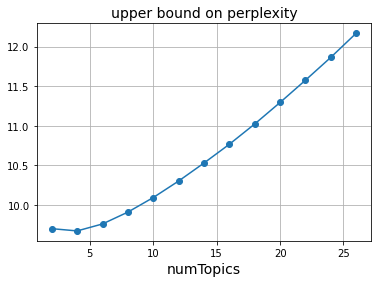

In [ ]:
import matplotlib.pyplot as plt
plt.plot(num,perplex, marker='o')
plt.title('upper bound on perplexity', fontsize=14)
plt.xlabel('numTopics', fontsize=14)
plt.grid(True)
plt.show()

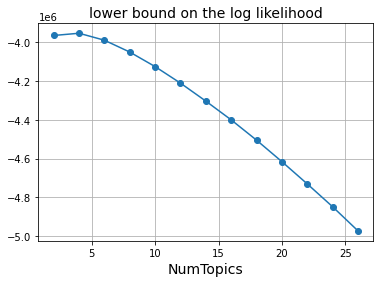

In [ ]:
plt.plot(num,loglike, marker='o')
plt.title("lower bound on the log likelihood", fontsize=14)
plt.xlabel('NumTopics', fontsize=14)
plt.grid(True)
plt.show()

Thus, it seems that the optimal number of topics is between 5 and 10; an eye estimated num = 6 will be utilized, where k = num.

In [ ]:
lda = LDA(k=6, maxIter=10, featuresCol='tf_idf_features')
lda_model = lda.fit(tfidf_result)

Extracting words that most embody defined topics. //reword

In [ ]:
vocab = tf_model.vocabulary

def get_words(token_list):
     return [vocab[token_id] for token_id in token_list]
       
udf_to_words = F.udf(get_words, T.ArrayType(T.StringType()))
num_top_words = 10

topics = lda_model.describeTopics(num_top_words).withColumn('topicWords', udf_to_words(F.col('termIndices')))
topics.select('topic', 'topicWords').show(truncate=90)

+-----+------------------------------------------------------------------------------------------+
|topic|                                                                                topicWords|
+-----+------------------------------------------------------------------------------------------+
|    0|                           [like, im, feel, know, else, dpdr, better, dont, time, getting]|
|    1|                       [real, cant, like, im, feel, really, dpdr, anyone, feel_real, even]|
|    2|            [deja_vu, youre, questions, thank, inner_voice, vu, dpdr, research, lot, like]|
|    3|             [im, thoughts, things, like, anxiety, thought, feel, body, existential, know]|
|    4|[anyone, therapist, cause, say, experiences, done, similar_experiences, everyone, today...|
|    5|                         [feel, like, dpdr, anyone, im, dont, see, people, didnt, feeling]|
+-----+------------------------------------------------------------------------------------------+

